In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybamm
from pybamm import constants,exp,sqrt
from time import time


print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

24.9.0


In [2]:
cell_nums = [1,4,7,10]

In [3]:
eSOH_DIR = "./Ageing_estimation/"
df_cells = [] # Ageing exp 결과
for i,cell in enumerate(cell_nums):
    df_cell_temp = pd.read_csv(eSOH_DIR + f"Ageing_estimation_results_rev_{cell:02d}.csv")
    df_cells.append(df_cell_temp) 

In [4]:
deg_param_candi = [[50, -0.036, 0, 7.52e-11, 0.26]]

In [5]:
cell_info = pd.read_csv('initial data of each cell.csv')
cell_info_target = cell_info.loc[np.array(cell_nums)-1].reset_index(drop=True).copy()
eps_n_data = cell_info_target['eps_n'].values
eps_p_data = cell_info_target['eps_p'].values
charge_cs = cell_info_target['charge_c'].values
discharge_cs = cell_info_target['discharge_c'].values
cycle_numbers = cell_info_target['n_cycle'].values
amb_T_Ks = cell_info_target['amb_T'].values+273.15
init_T_Ks = cell_info_target['init_T'].values+273.15
init_Cn =  cell_info_target['Cn'].values
init_Cp =  cell_info_target['Cp'].values
init_y0 = cell_info_target['y0'].values
init_x0 = cell_info_target['x0'].values

In [6]:
param = pybamm.ParameterValues("Jeong2024")

options = {"thermal":"lumped","SEI": "ec reaction limited","SEI porosity change":"true","loss of active material":"current and stress-driven","particle mechanics":"swelling only","lithium plating": "irreversible", "lithium plating porosity change": "true"}
model = pybamm.lithium_ion.SPM(options)

In [7]:
SOL = []
SOL_init = []
for k, cell_num in enumerate(cell_nums):
    n_cycle = int(cycle_numbers[k])
    experiment = pybamm.Experiment(
        [(pybamm.step.c_rate(-charge_cs[k], termination="4.2V", period='5 minutes'),
          pybamm.step.voltage(4.2, termination="C/50", period='5 minutes'),
          pybamm.step.c_rate(discharge_cs[k], termination='3.0V', period='5 minutes')
          )] * n_cycle)
    param["Initial temperature [K]"] = init_T_Ks[k]
    param["Ambient temperature [K]"] = amb_T_Ks[k]
    param["Negative electrode active material volume fraction"] = eps_n_data[k]
    param["Positive electrode active material volume fraction"] = eps_p_data[k]
    param["Initial stoichiometry in negative electrode"] = init_x0[k]
    param["Initial stoichiometry in positive electrode"] = init_y0[k]

    solver = pybamm.CasadiSolver(mode='safe', return_solution_if_failed_early=True)
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values=param, solver=solver)
    sol = sim.solve(initial_soc=0)
    SOL.append(sol.summary_variables)

    esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(param, pybamm.LithiumIonParameters())
    inputs = {"V_min": 3.0, "V_max": 4.2, "Q_n": sol['Negative electrode capacity [A.h]'].entries[0],
              "Q_p": sol['Positive electrode capacity [A.h]'].entries[0],
              "Q_Li": sol['Total lithium capacity in particles [A.h]'].entries[0]}
    esoh_sol = esoh_solver.solve(inputs)
    sol_init = [sol['Negative electrode capacity [A.h]'].entries[0],
                sol['Positive electrode capacity [A.h]'].entries[0],
                sol['Total lithium in particles [mol]'].entries[0], esoh_sol['Q']]
    SOL_init.append(sol_init)

Results = [SOL, SOL_init]

In [8]:
results = []
results_init = []
results.append(SOL)
results_init.append(SOL_init)

In [9]:
# To organize solutions in dataframe
df_SOLs = []
for i in range(len(results)):
    df_sols = []
    for j in range(len(results[i])):
        # Simulation results
        sol_temp = results[i][j]
        df_sol_temp = pd.DataFrame([sol_temp['Cycle number'],sol_temp['Negative electrode capacity [A.h]'],sol_temp['Positive electrode capacity [A.h]'],sol_temp['Total lithium in particles [mol]'],sol_temp['Capacity [A.h]']]).transpose()
        df_sol_temp.columns = ['Cycle number','Cn', 'Cp','n_Li','C']
        
        # Initial eSOH results
        df_sol_0 = pd.DataFrame(np.concatenate(([int(0)],results_init[i][j]))).transpose()
        df_sol_0.columns = ['Cycle number','Cn', 'Cp','n_Li','C']

        df_sol_temp = pd.concat([df_sol_0,df_sol_temp]).reset_index(drop=True)

        df_sol_temp['LAMn [%]'] = (1-df_sol_temp['Cn']/df_sol_temp['Cn'][0])*100
        df_sol_temp['LAMp [%]'] = (1-df_sol_temp['Cp']/df_sol_temp['Cp'][0])*100
        df_sol_temp['LLI [%]'] = (1-df_sol_temp['n_Li']/df_sol_temp['n_Li'][0])*100
        df_sol_temp['SOH [%]'] = df_sol_temp['C']/df_sol_temp['C'][0]*100
        
        df_sols.append(df_sol_temp)
    df_SOLs.append(df_sols)

In [10]:
def cost_function(df_compare):
    error_sum = 0
    weight = [1,1,25,1]
    for i,d in enumerate(['Cn','Cp','n_Li','C']):
        error_sum +=((weight[i]*(df_compare[d+'_x']-df_compare[d+'_y']))**2).sum()
    error_sum = error_sum/len(df_compare)
    return error_sum

# Cost 계산
COST_SOLs = []
for d in range(len(deg_param_candi)):
    cost_sols = []
    for k in range(len(cell_nums)):
        df_cell_temp = df_cells[k].copy()
        df_sol_temp = df_SOLs[d][k].copy()        
        df_compare = pd.merge(df_cell_temp[['Cycle number','Cn','Cp','n_Li','C']],df_sol_temp[['Cycle number','Cn','Cp','n_Li','C']],on='Cycle number',how='left') # x is experiment, y is simulation
        cost_sols.append(cost_function(df_compare))
    COST_SOLs.append(cost_sols)

cost_function_deg = np.mean(COST_SOLs,axis=1)

cost function:  0.03917502515757461


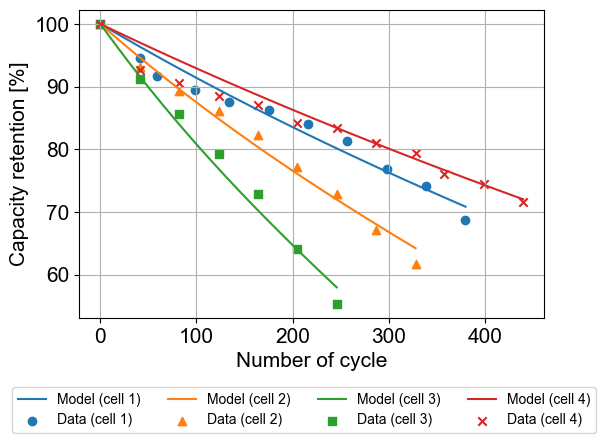

In [11]:
plt.rcParams['mathtext.fontset'] = 'cm'

d = 0
fig = plt.figure(1,figsize=(6,4))
print('cost function: ',cost_function_deg[d])
plt.grid()

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
markers = ['o','^','s','x',]

for i in range(len(cell_nums)):
    plt.plot(df_SOLs[d][i]["Cycle number"],(df_SOLs[d][i]['C']/df_SOLs[d][i]['C'][0])*100,label=f'Model (cell {i+1})',c=colors[i])
    plt.scatter(df_cells[i]['Cycle number'],(df_cells[i]['C']/df_cells[i]['C'][0])*100,label=f'Data (cell {i+1})',c=colors[i],marker=markers[i])


plt.xlabel('Number of cycle')
plt.ylabel('Capacity retention [%]')

fig.legend(loc='center',ncol=4, bbox_to_anchor=(0.5, -0.12),fontsize=10)
plt.show()